# Random forest model using a single day's observations

## Import libraries

In [1]:
# Accelerate scikit learn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier

## Load data

In [3]:
data = pd.read_csv('../output/sim_1_zero_onset.csv')

## Random forest model fitted to individual days

In [4]:
results = []
days = np.arange(0,50,1)

for day in days:
    mask = data['day'] == day
    day_data = data[mask]
    
    # Remove infants who have died
    mask = day_data['died'] == 0
    day_data = day_data[mask]
    
    # Use boot strap k_folds
    for k in range(30):

        # Split into train and test
        ids = list(set(day_data['patient_id']))
        random.shuffle(ids)
        count_ids = len(ids)
        train_count = int(count_ids) * 0.8
        train_ids = ids[0:(int(train_count))]
        test_ids = ids[(int(train_count)):]
        
        f = lambda x: x in train_ids
        mask = day_data['patient_id'].map(f)
        train = day_data[mask]
        f = lambda x: x in test_ids
        mask = day_data['patient_id'].map(f)
        test = day_data[mask]
    
        # Get X and y
        X_fields = ['gi', 'pulmonary', 'brain']
        X_train = train[X_fields]
        X_test = test[X_fields]
        y_train = train['condition']
        y_test = test['condition']

        # Fit model
        model = RandomForestClassifier(n_jobs=-1)
        model.fit(X_train,y_train)

        # Get accuracy and probabiltiies
        y_pred_test = model.predict(X_test)
        y_pred_prob = []
        prob = model.predict_proba(X_test)
        for indx, p in enumerate(prob):
            y_pred_prob.append(p[y_pred_test[indx]])
        accuracy = np.mean(y_pred_test == y_test)
        mean_probability = np.mean(y_pred_prob)
        day_results = dict()
        day_results['day'] = day
        day_results['k_fold'] = k
        day_results['accuracy'] = accuracy
        day_results['mean_probability'] = mean_probability
        results.append(day_results)
    
results = pd.DataFrame(results)

# Calculate mean results
cols_without_kfold = list(results); cols_without_kfold.remove('k_fold')
cols_to_average = ['day']
av_results = results[cols_without_kfold].groupby(cols_to_average).mean()
av_results = av_results.reset_index()

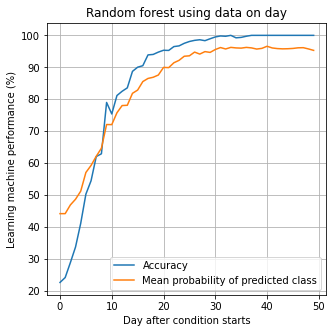

In [5]:
# Set up figure
fig = plt.figure(figsize=(5,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(av_results['day'], av_results['accuracy']*100, label='Accuracy')
ax.plot(av_results['day'], av_results['mean_probability']*100, 
        label='Mean probability of predicted class')
ax.set_xlabel('Day after condition starts')
ax.set_ylabel('Learning machine performance (%)')
ax.set_title('Random forest using data on day')

plt.grid()
plt.legend()
plt.savefig('./rf_single_day.png', dpi=300)
plt.show()